In [12]:
import dataclasses
import functools

import jax
from jax import numpy as jnp
import numpy as np

from flax import linen
from flax import struct
import optax
from tensorflow_probability.substrates import jax as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

import gym

import daves_rl_lib
from daves_rl_lib import networks
from daves_rl_lib.environments import environment_lib
from daves_rl_lib.algorithms import deep_q_network
from daves_rl_lib.internal import video_util

from matplotlib import pylab as plt
video_util.initialize_virtual_display()

Display already initialized; doing nothing.


In [7]:
buffer_size = 2048
epsilon = 0.05
discount_factor = 0.99
learning_rate = 0.01
gradient_batch_size = 64
target_weights_decay = 0.98

In [10]:
env = environment_lib.GymEnvironment(
    gym.make("CartPole-v1"), discount_factor=discount_factor)
qvalue_net = networks.make_model([24, 24, env.action_space.num_actions],
                                 obs_size=env.observation_size)
qvalue_optimizer = optax.adam(learning_rate)
learner = deep_q_network.initialize_learner(
    env=env,
    qvalue_net=qvalue_net,
    qvalue_optimizer=qvalue_optimizer,
    buffer_size=buffer_size,
    batch_size=None,
    seed=jax.random.PRNGKey(0))

step_learner = deep_q_network.compile_deep_q_update_step_stateful(
    env=env,
    qvalue_net=qvalue_net,
    qvalue_optimizer=qvalue_optimizer,
    gradient_batch_size=gradient_batch_size,
    target_weights_decay=target_weights_decay,
    epsilon=epsilon)
initial_obs = learner.agent_states.observation

In [9]:
actions = []
durations = []
returns = []
while len(durations) < 500:
    learner = step_learner(learner)
    #actions.append(learner.last_action)
    #done.append(learner.agent_states.done)
    #observations.append(learner.agent_states.observation)
    if learner.agent_states.done:
        print("Episode {} finished after {} steps with return {:.2f}".format(
            len(durations),
            learner.agent_states.num_steps,
            learner.agent_states.episode_return))
        durations.append(learner.agent_states.num_steps)
        returns.append(learner.agent_states.episode_return)


Episode 0 finished after 9 steps with return 8.65
Episode 1 finished after 10 steps with return 9.56
Episode 2 finished after 9 steps with return 8.65
Episode 3 finished after 11 steps with return 10.47
Episode 4 finished after 8 steps with return 7.73
Episode 5 finished after 9 steps with return 8.65
Episode 6 finished after 10 steps with return 9.56
Episode 7 finished after 10 steps with return 9.56
Episode 8 finished after 23 steps with return 20.64
Episode 9 finished after 11 steps with return 10.47
Episode 10 finished after 12 steps with return 11.36
Episode 11 finished after 15 steps with return 13.99
Episode 12 finished after 14 steps with return 13.13
Episode 13 finished after 11 steps with return 10.47
Episode 14 finished after 19 steps with return 17.38
Episode 15 finished after 61 steps with return 45.83
Episode 16 finished after 86 steps with return 57.87
Episode 17 finished after 84 steps with return 57.01
Episode 18 finished after 76 steps with return 53.41
Episode 19 fin

Text(0.5, 1.0, 'Episode durations')

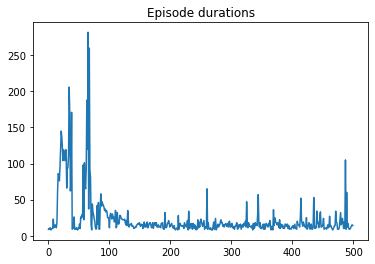

In [15]:
plt.plot(durations)
plt.title('Episode durations')

In [5]:
print("Estimated value", qvalue_net.apply(learner.qvalue_weights, initial_obs))
print("Mean reward", np.mean(
            learner.replay_buffer.valid_transitions().next_state.reward))

Estimated value [288.47754 270.03674]
Mean reward 1.0


In [ ]:
images = []
# Collect frames to visualize.
for step in range(512):
    learner = step_learner(learner)
    images.append(env._gym_env.render(mode="rgb_array"))

In [6]:
video_util.display_frames(images, frames_per_second=15)